<a href="https://colab.research.google.com/github/allifizzuddin89/Malaria-Prediction/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content/drive/MyDrive/COLAB/Malaria detection


In [ ]:
import os
os.chdir('/content/drive/MyDrive/COLAB/Malaria detection')

In [ ]:
#just in case if the image dataset is not splitted yet
#pip install split-folders
#'Data' is the dir or image dataset folder name
#import split_folders
#split_folders.ratio('Data', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


Creating CNN From Scratch and Transfer Learning
1. Transfer Learning


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
 #resize image to 224 px
 Image_size = [224, 224]

#path dir in google drive
#generate test, train data before call here
 train_path = "/content/drive/MyDrive/COLAB/Malaria detection/dataset/Train"
 test_path = "/content/drive/MyDrive/COLAB/Malaria detection/dataset/Test"

In [ ]:
vgg19 = VGG19(input_shape=Image_size + [3], weights='imagenet', include_top=False) # [3] is rgb channel

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#dont train existing weights since we are using transfer learning
#retraining only happen in last layer

for layer in vgg19.layers:
  layer.trainable = False

In [ ]:
#useful to get number of output class
folders = glob("/content/drive/MyDrive/COLAB/Malaria detection/dataset/Train/*") 

In [ ]:
folders

['/content/drive/MyDrive/COLAB/Malaria detection/dataset/Train/Parasite',
 '/content/drive/MyDrive/COLAB/Malaria detection/dataset/Train/Uninfected']

In [ ]:
#our layers - can add more
x = Flatten()(vgg19.output)

In [ ]:
#dense layer
#sigmoid activation more suitable for binary classification, 1 node
#in this case 2 nodes at output layers
prediction = Dense(len(folders), activation='softmax')(x) 

#create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [ ]:
#structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(
    loss='categorical_crossentropy', #2 nodes output layer, 1node=binary_crossentropy
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
#Use the Image Generator to import the images from dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#rescale the pixel to 0-1, max pixel density for rgb is 255, so divide by 255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

#only scaling, no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#make sure target size is exactly same as initialized for image size
training_set = train_datagen.flow_from_directory('dataset/Train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 416 images belonging to 2 classes.


In [ ]:
training_set

In [ ]:
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 134 images belonging to 2 classes.


In [ ]:
test_set

In [ ]:
#fit the model

detect = model.fit(
    training_set,
    validation_data=test_set,
    epochs=6,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/6
13/13 [==============================] - 6s 450ms/step - loss: 0.2821 - accuracy: 0.8726 - val_loss: 0.4275 - val_accuracy: 0.7761
Epoch 2/6
13/13 [==============================] - 6s 438ms/step - loss: 0.2392 - accuracy: 0.9183 - val_loss: 0.3243 - val_accuracy: 0.8731
Epoch 3/6
13/13 [==============================] - 6s 436ms/step - loss: 0.2659 - accuracy: 0.8822 - val_loss: 0.3220 - val_accuracy: 0.8433
Epoch 4/6
13/13 [==============================] - 6s 441ms/step - loss: 0.2320 - accuracy: 0.9087 - val_loss: 0.4022 - val_accuracy: 0.7836
Epoch 5/6
13/13 [==============================] - 6s 441ms/step - loss: 0.2066 - accuracy: 0.9279 - val_loss: 0.2856 - val_accuracy: 0.9030
Epoch 6/6
13/13 [==============================] - 6s 438ms/step - loss: 0.2062 - accuracy: 0.9351 - val_loss: 0.3559 - val_accuracy: 0.8209


<function matplotlib.pyplot.show>

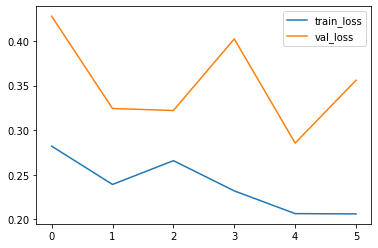

In [ ]:
#plot the loss 
plt.plot(detect.history['loss'], label='train_loss')
plt.plot(detect.history['val_loss'], label='val_loss')
plt.legend()
plt.show

In [ ]:
#save the model as h5 file

from tensorflow.keras.models import load_model
model.save('model_vgg19.h5')

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

#the position array, n, refers to image file in the test folder
#1st element in array refers to image in test\parasite while 2nd element refers to test\unineffected
#combination those 2 elements shall produce value of 1

array([[6.30923659e-02, 9.36907649e-01],
       [9.68129396e-01, 3.18706185e-02],
       [1.33515805e-01, 8.66484225e-01],
       [2.36064404e-01, 7.63935626e-01],
       [5.92759736e-02, 9.40724015e-01],
       [2.20056817e-01, 7.79943168e-01],
       [9.68118668e-01, 3.18813361e-02],
       [4.20648277e-01, 5.79351664e-01],
       [6.36621535e-01, 3.63378465e-01],
       [8.83691907e-01, 1.16308086e-01],
       [5.22293925e-01, 4.77706075e-01],
       [6.91503227e-01, 3.08496743e-01],
       [9.65982795e-01, 3.40172425e-02],
       [2.36947894e-01, 7.63052106e-01],
       [2.13096127e-01, 7.86903918e-01],
       [3.29761982e-01, 6.70238018e-01],
       [4.92462486e-01, 5.07537484e-01],
       [9.73516226e-01, 2.64837798e-02],
       [5.39089799e-01, 4.60910171e-01],
       [6.33848235e-02, 9.36615109e-01],
       [1.67611301e-01, 8.32388699e-01],
       [9.66428518e-01, 3.35715488e-02],
       [1.32113442e-01, 8.67886543e-01],
       [7.38455579e-02, 9.26154494e-01],
       [1.530277

In [ ]:
import numpy as np

#get the index of the biggest element 
y_pred = np.argmax(y_pred, axis=1) 

In [ ]:
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1])

Test on some image

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
img = image.load_image('/content/drive/MyDrive/COLAB/Malaria detection/dataset/Test/C39P4thinF_original_IMG_20150622_105803_cell_93.png')

In [ ]:
#convert image into array

x = image.img_to_array(img)
x

In [ ]:
#numpy array, (height,width,color channel)
x.shape

In [ ]:
#since we train our data in scale of 0-1 for pixel density, we have to rescale 
#our test image too
x = x/255

In [ ]:
#expand the array to be (batch_process, height, width, color channel)
#this to prepare for CNN, 4d tensor
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
img_data.shape

In [ ]:
model.predict(img_data)

In [ ]:
a = np.argmax(model.predict(img_data),axis=1)

In [ ]:
if(a==1):
  print('Uninfected')
else:
  print('Infected')

2. From Scratch

In [ ]:
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
#create CNN from scatch
model1 = Sequential()
model1.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu", input))

SyntaxError: ignored